# Exploratory Data Analysis

This notebook explores the complete dataset of the project in TDT4215

In [93]:
# Notebook settings
from tqdm.notebook import trange, tqdm
%alias_magic t timeit
# Settings and imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils

import implicit

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


## Load the dataset

This loads the complete dataset with all fields. At the moment the `all_data.csv` is missing some values (unknown why) so the files are merged to restore categories and publishTime (uncertain whether other data has been lost).

In [2]:
# Load data
df = utils.load_csv(module_path + '/data/all_data.csv')

In [3]:
from utils import load_events

events = load_events(module_path + '/active1000')

In [4]:
# Reconstruct df with category data (and other missing data)
df_merged = pd.merge(left=df, right=events, on='eventId', how='left', suffixes=[None, '_events'])

# Cleanup after merge to original fields
df_full = df_merged.drop(columns=['category', 'publishTime'], axis=1)
df_full.rename(columns={'category_events': 'category', 'publishtime': 'publishTime'}, inplace=True)
df_full.drop(df_full.filter(regex='_events$').columns.tolist(), axis=1, inplace=True)

Overview of dataset:

In [5]:
df_full.sort_values(by='eventId').head()

,eventId,activeTime,os,deviceType,userId,city,country,region,time,url,title,keywords,author,documentId,category,publishTime
633723,71,2.0,iPhone OS,Mobile,cx:3t62xjqi1sj4mihiew9dwtkwz:2p6efggeo633t,trondheim,no,sor-trondelag,1485980571,http://adressa.no,NaN,NaN,NaN,NaN,None,None
949469,1586,NaN,iPhone OS,Mobile,cx:3dfh8zrlrd8tfbo5mnaesay1w:1r8zj7n5ld6ew,trondheim,no,sor-trondelag,1487019367,http://adressa.no,NaN,NaN,NaN,NaN,None,None
1168146,2047,NaN,Windows,Desktop,cx:2vwew3jn5z7x32gcvpe0a2k31r:3em6s8zfmi2gt,oslo,no,oslo,1487700518,http://adressa.no,NaN,NaN,NaN,NaN,None,None
857329,2306,NaN,iPhone OS,Tablet,cx:i5twuir0akye0wqf:15fn9728tiosp,surnadal,no,more og romsdal,1486678698,http://adressa.no/nyheter/innenriks/2017/02/09...,- Norsk nasjonalisme er en positiv kraft,"Politikk,Ola Borten Moe,Marit Arnstad,Senterpa...","['harry tiller', 'roy tommy bråten']",b9e03d56b32b8c60f5fe0df96a05b6b7bf0766b6,nyheter|innenriks,2017-02-09T20:56:12.000Z
255129,2647,99.0,iPhone OS,Mobile,cx:iaxm8oa0wp9dglfl:3e04urhoti30m,melhus,no,sor-trondelag,1484839049,http://adressa.no/nyheter/nordtrondelag/2017/0...,NaN,NaN,NaN,NaN,None,None


### Attributes

There is a total of 16 attributes for each event. Their description:

| Attribute   | Type   | Description                                                                                                                                                                                                                                           |
|-------------|--------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| eventId     | int    | The identifier used to differentiate distinct events from the same user.                                                                                                                                                                              |
| activeTime  | int    | The active time on a page in seconds, if known.                                                                                                                                                                                                       |
| os          | string | Operating system that the user used when log in.                                                                                                                                                                                                      |
| deviceType  | string | The type of device.                                                                                                                                                                                                                                   |
| userId      | string | The cross-site user identifier which can be used to differentiate device/browsers, or identify subscription users by the user id.                                                                                                                     |
| category    | string | The category of the news article.                                                                                                                                                                                                                     |
| city        | string | The city name inferred from the IP address.                                                                                                                                                                                                           |
| country     | string | The country code inferred from the user's IP address.                                                                                                                                                                                                 |
| region      | string | The region inferred from the user's IP address.                                                                                                                                                                                                       |
| time        | int    | The time of the event, measured in Unix time.                                                                                                                                                                                                         |
| url         | string | Canonical URL as calculated based on incoming events and the fetched page content.                                                                                                                                                                    |
| documentId  | string | The document id. This will be the same for different URLs that are considered equivalent according to Cxense’s normalization algorithm. E.g., http://www.example.com/, http://www.example.com and http://example.com will all have the same id value. |
| title       | string | The title of the article                                                                                                                                                                                                                              |
| keywords    | list   | The named entities of the article, including their types, counts and weights.                                                                                                                                                                         |
| author      | string | The author of the article.                                                                                                                                                                                                                            |
| publishTime | string | The publish time of the article.                                                                                                                                                                                                                      |

Example of event entry:

In [6]:
df_full[~df_full.isnull().any(axis=1)].iloc[[5]]

,eventId,activeTime,os,deviceType,userId,city,country,region,time,url,title,keywords,author,documentId,category,publishTime
204,1522705375,77.0,Windows,Desktop,cx:25keeu1fyal75150chjpjhsgbb:1hkvdvyhju9nl,hamarvik,no,sor-trondelag,1483226246,http://adressa.no/nyheter/sortrondelag/2016/12...,Hurtigruta snudde på Folda,"utenriks,innenriks,trondheim,E6,midtbyen,bybra...",harry tiller,1d6279f9e08156802519de2929346fd57e974ff1,nyheter|sortrondelag,2016-12-31T12:31:47.000Z


## Analysis

This section analyses the complete dataset. The dataframe `df` contains all data we want to examine. A short statistical overview of the dataset:

In [7]:
from tools import statistics
statistics(df)

Total number of events (front page incl.): 2207608
Total number of events (without front page): 788931
Total number of documents: 20344
Sparsity: 3.878%
Total number of events (drop duplicates): 679355
Sparsity (drop duplicates): 3.339%

Describe by user:
            counts
count  1000.000000
mean    679.355000
std     333.619737
min      59.000000
25%     506.750000
50%     639.500000
75%     797.500000
max    7958.000000


### Sparsity

Here we explore how sparse (or dense) the dataset is.

Number of `None` values for each attribute:

In [8]:
print(df_full.isnull().sum())

eventId              0
activeTime      857417
os                   0
deviceType           0
userId               0
city              3471
country           3338
region            3338
time                 0
url                  0
title          1421055
keywords       1478958
author         1498326
documentId     1421055
category       1600360
publishTime    1481365
dtype: int64


A closer look at the dataset with complete entries:

In [9]:
statistics(df_full[~df_full.isnull().any(axis=1)])

Total number of events (front page incl.): 308289
Total number of events (without front page): 308289
Total number of documents: 8923
Sparsity: 3.455%
Total number of events (drop duplicates): 272538
Sparsity (drop duplicates): 3.054%

Describe by user:
            counts
count   994.000000
mean    274.183099
std     210.574629
min       2.000000
25%      96.000000
50%     225.000000
75%     408.000000
max    1187.000000


### Preprocessing

Since the dataset is prune to containing empty values in very interesting fields, imputing fields with clever values may provide valuable to obtain decent recommendation engines.

#TODO: check up imputing data vs dropping

### EDA

An exploratory data analysis. Exploring articles, users and potential implicit feedback to be used as "rating".

In [10]:
# All unique articles dataframe
articles = df_full[~df_full['documentId'].isna()].drop_duplicates('documentId')  #.set_index('documentId')

# All unique users dataframe
users = df_full[~df_full['userId'].isna()].drop_duplicates('userId')

In [11]:
print(articles.isnull().sum())

eventId            0
activeTime     12214
os                 0
deviceType         0
userId             0
city              13
country           13
region            13
time               0
url                0
title              0
keywords        5219
author          6238
documentId         0
category        7613
publishTime     5445
dtype: int64


In [58]:
# Overall data
n_events = len(df_full)

# Items
n_items = df_full['documentId'].nunique()

# Users
n_users = df_full['userId'].nunique()

#### Potential implicit feedbacks

From here on user referser to userId and item refers to documentId. This is a list of the suggested and/or explored options for implicit feedback (as there is no rating in the dataset this is necessary). Checked suggestions are marked as [x].

- [x] activeTime: In the rating matrix, it is the registered time period for the event between a user and a item
- [x] Binary click: In the rating matrix, clicked events are referred as 1 and others as 0 (this is done in the example_project.py)
- [ ] Cumulative clicks: In the rating matrix, number clicks for each item is entered as rating (uncertain if this makes sense?)
- [ ] 
- [ ] 

To use a new feature, just implement a method to populate the rating matrix:

In [56]:
ratings = np.zeros((n_users, n_items))

In [14]:
total_active_time = df_full['activeTime'].sum()

print(f'Number of events: {n_events}')
print(f"Number of unique documentId's: {n_items}")
print(f"Number of unique users: {n_users}")
print(f"Average activeTime per user: {round(total_active_time/n_users, 2)}")
print(f"Average activeTime per document: {round(total_active_time/n_items, 2)}")

Number of events: 2210998
Number of unique documentId's: 20344
Number of unique users: 1000
Average activeTime per user: 60049.01
Average activeTime per document: 2951.68


Let's look closer at how the data distributes. Below we see how frequently the top most active users have had an event registered with an article as `n_readings`, i.e., on average a user will have accessed a document 789.94 over the entire dataset.

In [16]:
user_freq = df_full[['userId', 'documentId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_readings']
user_freq.head()
mean_readings = user_freq['n_readings'].mean()
print(f'Mean articles accessed for a given user: {mean_readings:.2f}')

Mean articles accessed for a given user: 789.94


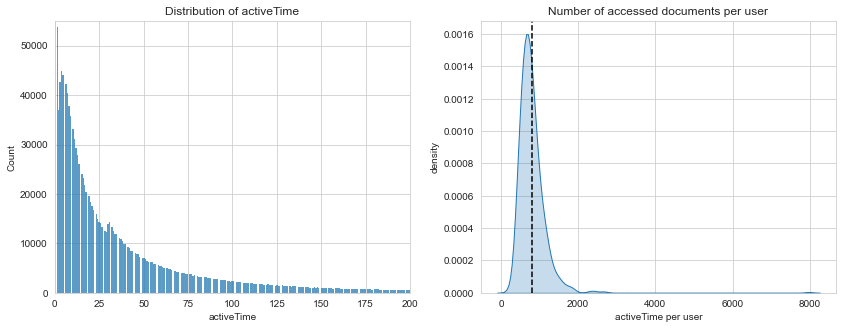

In [17]:
sns.set_style('whitegrid')
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
ax1 = sns.histplot(data=df_full['activeTime'])
ax1.set_xlim([0, 200])
ax1.set_ylim([0, 55000])
plt.title("Distribution of activeTime")

ax2 = plt.subplot(1, 2, 2)
ax2 = sns.kdeplot(user_freq['n_readings'], shade=True, legend=False)
plt.axvline(mean_readings, color='k', linestyle='--')
plt.xlabel('activeTime per user')
plt.ylabel('density')
plt.title('Number of accessed documents per user')
plt.show()

We clearly see how the activeTime resembles how a small number of products, in this case events, are more "popular", here given more activeTime, than other events. We also see that the most common activeTime for users ignoring the `NaN` values is around 4 seconds.

Other useful information such as articles with shortest and longest activeTime (ignoring `NaN`):

In [18]:
activeTime_documents = df_full[~df_full['activeTime'].isna()].groupby('documentId')[['activeTime']].mean()

shortest_activeTime = activeTime_documents['activeTime'].idxmin()
df_full.loc[df_full['documentId'] == shortest_activeTime]

,eventId,activeTime,os,deviceType,userId,city,country,region,time,url,title,keywords,author,documentId,category,publishTime
870646,999401185,1.0,Linux,Desktop,cx:ib1vo01vq38f2mqc:20lut6o1pv35i,lorenskog,no,akershus,1486734932,http://adressa.no/nyheter/utenriks/2017/02/10/...,DPA: Tysk minister vil kutte i barnetrygden fo...,NaN,NaN,009b7dd5aa26ced1c1135b925baa35cd2ebabfd9,None,None


In [19]:
longest_activeTime = activeTime_documents['activeTime'].idxmax()

df_full[~df_full['activeTime'].isna()].loc[df_full['documentId'] == longest_activeTime]

,eventId,activeTime,os,deviceType,userId,city,country,region,time,url,title,keywords,author,documentId,category,publishTime
406211,1146367693,823.0,Windows,Desktop,cx:14ibqfgfmaa4a24cenj9rgf2lz:3nnpj3jn9yna9,trondheim,no,sor-trondelag,1485292911,http://adressa.no/nyheter/adressa_noogda/artic...,Popgrupper på 1970-tallet,"utenriks,innenriks,trondheim,E6,midtbyen,bybra...",ingrid brissach,f62707043a8f01e35981c324532240f89af91be6,nyheter|adressa noogda,2014-08-09T21:39:04.000Z


Its also interesting to see that the number of events associated with the document with the longest activeTime is just 4:

In [20]:
df_full[df_full['documentId'] == longest_activeTime]

,eventId,activeTime,os,deviceType,userId,city,country,region,time,url,title,keywords,author,documentId,category,publishTime
168709,546110405,NaN,Windows,Desktop,cx:i90t5goml5anvrae:27htgkglyporz,haltdalen,no,sor-trondelag,1484556731,http://adressa.no/nyheter/adressa_noogda/artic...,Popgrupper på 1970-tallet,"utenriks,innenriks,trondheim,E6,midtbyen,bybra...",ingrid brissach,f62707043a8f01e35981c324532240f89af91be6,nyheter|adressa noogda,2014-08-09T21:39:04.000Z
169494,27772679,NaN,Windows,Desktop,cx:i90t5goml5anvrae:27htgkglyporz,haltdalen,no,sor-trondelag,1484559095,http://adressa.no/nyheter/adressa_noogda/artic...,Popgrupper på 1970-tallet,"utenriks,innenriks,trondheim,E6,midtbyen,bybra...",ingrid brissach,f62707043a8f01e35981c324532240f89af91be6,nyheter|adressa noogda,2014-08-09T21:39:04.000Z
406211,1146367693,823.0,Windows,Desktop,cx:14ibqfgfmaa4a24cenj9rgf2lz:3nnpj3jn9yna9,trondheim,no,sor-trondelag,1485292911,http://adressa.no/nyheter/adressa_noogda/artic...,Popgrupper på 1970-tallet,"utenriks,innenriks,trondheim,E6,midtbyen,bybra...",ingrid brissach,f62707043a8f01e35981c324532240f89af91be6,nyheter|adressa noogda,2014-08-09T21:39:04.000Z
851971,1395192641,NaN,Macintosh,Desktop,cx:i29htb5aoe26692l:1rt4ul0023dh4,trondheim,no,sor-trondelag,1486666619,http://adressa.no/nyheter/adressa_noogda/artic...,Popgrupper på 1970-tallet,"utenriks,innenriks,trondheim,E6,midtbyen,bybra...",ingrid brissach,f62707043a8f01e35981c324532240f89af91be6,nyheter|adressa noogda,2014-08-09T21:39:04.000Z


#### Dealing with empty values

There is a lot of empty attributes in the dataset (`NaN`). Hence, when an attribute is needed for a recommender engine e.g. as implicit feedback we have to remove the rows containing the values or interpolate them in some way. Usually, if there is a rationale behind imputing values this is preferred over just deleting the rows containing the `NaN`-values.

Different approaches for imputing data depend on the attribute in question. E.g. for activeTime it might be possible to replace with the mean for empty values, but an even more clever way to proceed would be to use the mean of the activeTimes for different categories to impute the data. The same yields true for keywords.


In [64]:
# users = users[users['user_id'].notna()]
# articles = articles[articles['document_id'].notna()]
# df = df[df['documentId'].notna() & df['userId'].notna() & df['activeTime'].notna()]
# df['categories'] = df['categories'].apply(lambda x: x.split("|"))
# df = df.astype({'title': 'str', 'url': 'str', 'userId': 'str', 'documentId': 'str'})

# preprocessing of entire df

# Replace empty activeTimes with the mean
# df['activeTim'].fillna(df['activeTime'].mean(), inplace = True)
# print(df.isnull().sum())

# ax = sns.countplot(x='activeTime', data=df_full, palette='cool_r')

# Remove empty categories from articles and make into list
articles_with_cat = df_full[df_full['category'].notna()]
articles_with_cat['category'] = articles_with_cat['category'].apply(lambda x: x.split('|'))
articles_with_cat.head()

,eventId,activeTime,os,deviceType,userId,city,country,region,time,url,title,keywords,author,documentId,category,publishTime
32,1445037239,NaN,iPhone OS,Mobile,cx:1a14ikdig4lse1yr7x4flb13dd:fo6lrl3k2wob,oslo,no,oslo,1483225613,http://adressa.no/nyheter/innenriks/2016/12/31/mange-nordmenn-vil-trene-mer-i-2017-14000934.ece,Én av tre nordmenn vil trene mer i 2017,"utenriks,innenriks,trondheim,E6,midtbyen,bybrann,bilulykker",ntb,080b1bbe40a36dda8cf11482647b8b534fec2226,"[nyheter, innenriks]",2016-12-31T22:47:54.000Z
42,24027473,90.0,Android,Mobile,cx:1e1f63c523ffl2soio74f5sp5n:bdwc2uq43w9w,trondheim,no,sor-trondelag,1483225658,http://adressa.no/100sport/sjakk/pa-dette-bildet-skiller-magnus-carlsen-seg-ut---litt-tilfeldig-...,På dette bildet skiller Magnus Carlsen seg ut: - Litt tilfeldig,Magnus Carlsen,nicholas bergh,05e4209b296dc7dfc9d4e0c401d79256bcea4cb5,"[100sport, sjakk]",2016-12-31T16:12:10.000Z
50,330189993,NaN,iPhone OS,Tablet,cx:1m0dupfv97gglk5u9yfw65lhl:2sjgjqpk418jv,trondheim,no,sor-trondelag,1483225723,http://adressa.no/nyheter/trondheim/2016/12/31/det-blir-fyrverkeri-14000281.ece,- Det blir fyrverkeri,"utenriks,innenriks,trondheim,E6,midtbyen,bybrann,bilulykker","['norunn bergesen', 'joakim slettebak wangen']",2607fc7d7b4c0ede839a5ff6d499fa428237443e,"[nyheter, trondheim]",2016-12-31T15:48:48.000Z
84,670227815,NaN,iPhone OS,Mobile,cx:if18acolhbyfdhug:1rng4vxjk91f2,trondheim,no,sor-trondelag,1483225902,http://adressa.no/nyheter/innenriks/2016/12/31/mange-nordmenn-vil-trene-mer-i-2017-14000934.ece,Én av tre nordmenn vil trene mer i 2017,"utenriks,innenriks,trondheim,E6,midtbyen,bybrann,bilulykker",ntb,080b1bbe40a36dda8cf11482647b8b534fec2226,"[nyheter, innenriks]",2016-12-31T22:47:54.000Z
110,1329919923,NaN,iPhone OS,Mobile,cx:3qgspqpx3bs6r15a2s9wjs8vnx:ld7dxj2thh73,trondheim,no,sor-trondelag,1483226014,http://adressa.no/nyheter/innenriks/2016/12/31/mange-nordmenn-vil-trene-mer-i-2017-14000934.ece,Én av tre nordmenn vil trene mer i 2017,"utenriks,innenriks,trondheim,E6,midtbyen,bybrann,bilulykker",ntb,080b1bbe40a36dda8cf11482647b8b534fec2226,"[nyheter, innenriks]",2016-12-31T22:47:54.000Z


In [65]:
# How many categories are there
from collections import Counter

# Count categories and appearance
category_counts = Counter(c for cat in articles_with_cat['category'] for c in cat)
print(f"There are {len(category_counts)} genre labels.")
category_counts

There are 82 genre labels.


Counter({'nyheter': 340615,
         'innenriks': 20767,
         '100sport': 150498,
         'sjakk': 609,
         'trondheim': 112434,
         'vintersport': 78434,
         'pluss': 165242,
         'magasin': 23536,
         'sortrondelag': 59751,
         'fotball': 45270,
         'kultur': 18957,
         'okonomi': 58251,
         'mesterskap': 36,
         'politikk': 1806,
         'nordtrondelag': 42210,
         'meninger': 33232,
         'moreromsdal': 5823,
         'sprek': 9001,
         'ordetfritt': 12839,
         'adressa noogda': 147,
         'utenriks': 11123,
         'sport': 1457,
         'tv': 292,
         'forbruker': 610,
         'hjem': 586,
         'tema': 181,
         'villeveier': 15,
         'bolig': 2438,
         'boligguiden': 2438,
         'ballsport': 11056,
         'andreidretter': 2368,
         'makteliten': 3,
         'film': 31,
         'kronikker': 1778,
         'oppdraget': 32,
         'arets tronder': 162,
         'idretts

In [66]:
# Most popular categories
print(f'The 5 most common categories are: \n', category_counts.most_common(5))

The 5 most common categories are: 
 [('nyheter', 340615), ('pluss', 165242), ('100sport', 150498), ('trondheim', 112434), ('vintersport', 78434)]


Here we see that the five most popular categories are nyheter (news), pluss (plus, paid subscription), 100sport, trondheim and vintersport (winter sports).

Visualization of the top 20 most popular categories:

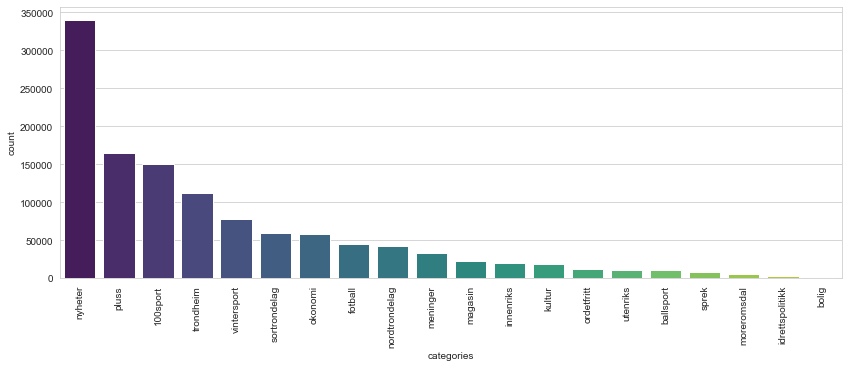

In [67]:
categories_counts_df = pd.DataFrame([category_counts]).T.reset_index()
categories_counts_df.columns = ['categories', 'count']
categories_counts_df = categories_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 5))
sns.barplot(x='categories', y='count', data=categories_counts_df.head(20), palette='viridis')
plt.xticks(rotation=90)
plt.show()

### Transforming data for content-based recommendation

In order to build a content-based filtering recommender, we need to set up our dataset so that rows represent movies and columns represent features (i.e., categories and city).

First, we need to manipulate the categories column so that each category is represented as a separate binary feature. "1" indicates that the article falls under a given category, while "0" does not.

In [68]:
articles['category']

15                          None
18                          None
32             nyheter|innenriks
34                          None
42                100sport|sjakk
                   ...          
2209965    nyheter|nordtrondelag
2210043      nyheter|moreromsdal
2210115                     None
2210398             pluss|kultur
2210582         100sport|fotball
Name: category, Length: 20344, dtype: object

In [69]:
categories = list(category_counts.keys())

# drop duplicates
articles_fc = articles_with_cat.drop_duplicates('documentId')

for c in categories:
    articles_fc[c] = articles_fc['category'].transform(lambda x: int(c in x))

In [70]:
# The article category columns then look like this
articles_fc[categories].head()

,nyheter,innenriks,100sport,sjakk,trondheim,vintersport,pluss,magasin,sortrondelag,fotball,...,innsyn,rockamiddag,anmeldt,snakkut,personlig okonomi,omadresseavisen,arrangementer,kvinner,utguiden,aretstronder
32,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
160,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Our category columns are now represented as binary features. The next step is to wrangle our e.g. deviceType feature so that each decade has its own column. We can do this using pandas' get_dummies() function, which works by creating a categorical variable into binary variables.

In [71]:
article_deviceType = pd.get_dummies(articles_fc['deviceType'])
article_deviceType.head()

,Desktop,Mobile,Tablet
32,0,1,0
42,0,1,0
50,0,0,1
159,1,0,0
160,1,0,0


In [72]:
article_features = pd.concat([articles_fc[categories], article_deviceType], axis=1)
article_features.head()

,nyheter,innenriks,100sport,sjakk,trondheim,vintersport,pluss,magasin,sortrondelag,fotball,...,snakkut,personlig okonomi,omadresseavisen,arrangementer,kvinner,utguiden,aretstronder,Desktop,Mobile,Tablet
32,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
42,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
50,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
159,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
160,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


The article_features dataframe is ready. The next step is to start building our recommender.

## Example: content-based recommender system

This shows a simple item-item recommender using a similarity metric called cosine similarity.

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(article_features, article_features)
print(f'Dimension of our article features cosine simlarity matrix: {cosine_sim.shape}')

Dimension of our article features cosine simlarity matrix: (12838, 12838)


In [31]:
from fuzzywuzzy import process

def article_finder(title):
    all_titles = articles_fc['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

In [32]:
title = article_finder('trene mer i 2017')
title

'Én av tre nordmenn vil trene mer i 2017'

In [33]:
article_idx = dict(zip(articles_fc['title'], list(articles_fc.index)))
idx = article_idx[title]
idx

32

In [34]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations + 1)]
similar_articles = [i[0] for i in sim_scores]

In [35]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
print(f'Since you read the article {title}, we think you would like: ')
articles_fc['title'].iloc[similar_articles]

Since you read the article Én av tre nordmenn vil trene mer i 2017, we think you would like: 


9306      Hva gjør restaurantene Frati og Bari i en romantisk amerikansk julefilm?
15904                                      Her er dama som jubler for sprengkulden
17106                                                   Iiiiiiiiiskaldt nyttårsbad
22336                            Her eksploderer fyrverkeriet to meter over bakken
25786                                                        Rystet over rapporten
29252    «Det ser ut til å bli et kult bygg. Området er ikke særlig fint fra før.»
29277                                               Vurderer å flytte fra Midtbyen
30367                                         Strør og salter alle kommunale veier
30959                                         Her er Adresseavisens nye redaktører
31820                                                     - Vi hørte et høyt smell
Name: title, dtype: object

## Example: Collaborative filtering recommender system

This shows a simple item-based Collaborative Filtering (CF) recommender using Alternating Least Squares.

In [76]:
dataset = df[~df['documentId'].isnull()]

dataset = dataset.drop_duplicates(subset=['userId', 'documentId']).reset_index(drop=True)
dataset = dataset.sort_values(by=['userId', 'time'])
n_users = dataset['userId'].nunique()
n_items = dataset['documentId'].nunique()

ratings = np.zeros((n_users, n_items))
new_user = dataset['userId'].values[1:] != dataset['userId'].values[:-1]
new_user = np.r_[True, new_user]
dataset['uid'] = np.cumsum(new_user)
item_ids = dataset['documentId'].unique().tolist()
new_df = pd.DataFrame({'documentId':item_ids, 'tid':range(1,len(item_ids)+1)})
dataset = pd.merge(dataset, new_df, on='documentId', how='outer')
df_ext = dataset[['uid', 'tid']]

for row in df_ext.itertuples():
    ratings[row[1]-1, row[2]-1] = 1.0

ratings

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [77]:
# Transforming the data
from scipy.sparse import csr_matrix

def create_matrices(df):
    """
    Generates a sparse matrix from dataframe ratings

    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's

    """
    N = df['userId'].nunique()
    M = df['documentId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    article_mapper = dict(zip(np.unique(df["documentId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    article_inv_mapper = dict(zip(list(range(M)), np.unique(df["documentId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    article_index = [article_mapper[i] for i in df['documentId']]

    # Create implicit feedback, rating
    X = csr_matrix((df["activeTime"], (article_index, user_index)), shape=(M, N))
    
    return X, user_mapper, article_mapper, user_inv_mapper, article_inv_mapper

In [78]:
X, user_mapper, article_mapper, user_inv_mapper, article_inv_mapper = create_matrices(dataset)

In [80]:
from fuzzywuzzy import process

def article_finder(title):
    all_titles = articles['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

article_title_mapper = dict(zip(articles['title'], articles['documentId']))
article_title_inv_mapper = dict(zip(articles['documentId'], articles['title']))

def get_article_index(title):
    fuzzy_title = article_finder(title)
    article_id = article_title_mapper[fuzzy_title]
    article_idx = article_mapper[article_id]
    return article_idx

def get_article_title(article_idx): 
    article_id = article_inv_mapper[article_idx]
    title = article_title_inv_mapper[article_id]
    return title

In [81]:
# Test
get_article_index('Se lesernes nyttårsbilder')

12563

In [82]:
# Other way around
get_article_title(12563)s

'Se lesernes nyttårsbilder'

In [114]:
# Train test split
from sklearn.model_selection import train_test_split
train, cros_val = train_test_split(X, test_size = 0.2, random_state = 1)
train, test = train_test_split(train, test_size = 0.25, random_state = 1)

In [115]:
print('Splitted dataset into train set, cross validation set and test set')
print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('cros_val shape:',cros_val.shape)

Splitted dataset into train set, cross validation set and test set
Train shape: (12206, 1000)
Test shape: (4069, 1000)
cros_val shape: (4069, 1000)


In [127]:
# Replace NaN values with 0.0
train.data[np.isnan(train.data)] = 0.0
train.data[np.isinf(train.data)] = 0.0

In [179]:
c = train.tocoo()

out = pd.DataFrame({"Article": c.row, "User": c.col, "Rating": c.data})
out                                 

,Article,User,Rating
0,0,465,0.0
1,1,100,0.0
2,1,126,20.0
3,1,144,12.0
4,1,159,0.0
...,...,...,...
403255,12205,968,0.0
403256,12205,980,80.0
403257,12205,992,105.0
403258,12205,993,0.0


In [180]:
model = implicit.als.AlternatingLeastSquares()

In [182]:
model.fit(train)

100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


In [183]:
# Choose random user to run on the test set
user_of_interest = 132

ids, scores = model.recommend(user_of_interest, test[user_of_interest], N=10, filter_already_liked_items=False)

In [184]:
ids

array([223, 586,  86, 874, 522, 904, 431, 481, 822, 804], dtype=int32)

<10x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 182 stored elements in Compressed Sparse Row format>

In [241]:
# Find articles corresponding to mapping
c = test[ids].tocoo()
out = pd.DataFrame({"Article": c.row, "User": c.col, "Rating": c.data})["Article"].unique()

# Test with translating through test set mapping
recommended_articles = []
for id_ in out:
    articles_without_duplicates = articles.drop_duplicates(subset=['documentId'])
    value = articles_without_duplicates[articles_without_duplicates["documentId"] == article_inv_mapper[id_]]["title"].values[0]
    print(value)
    recommended_articles.append(value)
# # Test without translating through test set mapping
# for id_ in ids:
#     print(articles[articles["documentId"] == article_inv_mapper[id_]]["title"].values[0])

Midt i løpet måtte Østberg endre taktikken: – Jeg var forbannet etter i går
- Denne galskapen må stoppes
Upopulær, men nødvendig politireform
«Publikum har endelig oppdaget Kosmorama»
Nå kommer «regler» for hvor lenge en sykmelding bør vare (PLUSS)
Mobile vanntåkeanlegg redder liv
Listhaug i full korskrangel
Vanlig norsk mager kost førte til at jeg ble 120 kg. Nå spiser jeg det ekspertene sier er farlig, og har fått et nytt liv
Her er superbuss-traseene
Unge asylsøkere som forsvinner, er desperate og uten rettssikkerhet


In [242]:
recommended_articles

['Midt i løpet måtte Østberg endre taktikken: – Jeg var forbannet etter i går',
 '- Denne galskapen må stoppes',
 'Upopulær, men nødvendig politireform',
 '«Publikum har endelig oppdaget Kosmorama»',
 'Nå kommer «regler» for hvor lenge en sykmelding bør vare (PLUSS)',
 'Mobile vanntåkeanlegg redder liv',
 'Listhaug i full korskrangel',
 'Vanlig norsk mager kost førte til at jeg ble 120 kg. Nå spiser jeg det ekspertene sier er farlig, og har fått et nytt liv',
 'Her er superbuss-traseene',
 'Unge asylsøkere som forsvinner, er desperate og uten rettssikkerhet']

In [243]:
pd.DataFrame({"Articles": recommended_articles, "score": scores, "already_clicked": np.in1d(ids, train[user_of_interest].indices)})

,Articles,score,already_clicked
0,Midt i løpet måtte Østberg endre taktikken: – Jeg var forbannet etter i går,1.016206,True
1,- Denne galskapen må stoppes,1.006686,True
2,"Upopulær, men nødvendig politireform",0.966449,True
3,«Publikum har endelig oppdaget Kosmorama»,0.938938,True
4,Nå kommer «regler» for hvor lenge en sykmelding bør vare (PLUSS),0.938010,True
5,Mobile vanntåkeanlegg redder liv,0.925497,True
6,Listhaug i full korskrangel,0.870800,True
7,Vanlig norsk mager kost førte til at jeg ble 120 kg. Nå spiser jeg det ekspertene sier er farlig...,0.861879,True
8,Her er superbuss-traseene,0.858692,True
9,"Unge asylsøkere som forsvinner, er desperate og uten rettssikkerhet",0.672720,False


In [259]:
# To see whether the recommendation was any good, we check whether the user actually clicked the recommended article in the test set:
c = test.tocoo()
check = pd.DataFrame({"Article": c.row, "User": c.col, "Rating": c.data})
check[check["User"] == 132]["Article"].values

actually_clicked = []
for id_ in out:
    articles_without_duplicates = articles.drop_duplicates(subset=['documentId'])
    value = articles_without_duplicates[articles_without_duplicates["documentId"] == article_inv_mapper[id_]]["title"].values[0]
    # print(value)
    actually_clicked.append(value)
actually_clicked[:10]

['Midt i løpet måtte Østberg endre taktikken: – Jeg var forbannet etter i går',
 '- Denne galskapen må stoppes',
 'Upopulær, men nødvendig politireform',
 '«Publikum har endelig oppdaget Kosmorama»',
 'Nå kommer «regler» for hvor lenge en sykmelding bør vare (PLUSS)',
 'Mobile vanntåkeanlegg redder liv',
 'Listhaug i full korskrangel',
 'Vanlig norsk mager kost førte til at jeg ble 120 kg. Nå spiser jeg det ekspertene sier er farlig, og har fått et nytt liv',
 'Her er superbuss-traseene',
 'Unge asylsøkere som forsvinner, er desperate og uten rettssikkerhet']

## Other code

All code below is saved for later and not usable.

In [ ]:
import scipy.sparse as sparse
user_items = sparse.csr_matrix((train['activeTime'].astype(int),(train['userId'], train['documentId'])))
item_users = sparse.csr_matrix((train['activeTime'].astype(int),(train['documendId'], train['userId'])))

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
# Function to impute numerical activeTime on empty values based on categorical column which can be e.g. category, publishtime, etc.
def impute_numerical(categorical_column, numerical_column):
    frames = []
    # df['categories'] = df['category'].apply(lambda x: x.split("|"))
    for i in list(set(df[categorical_column])):
        df_category = df[df[categorical_column] == i]
        if len(df_category) > 1:    
            df_category[numerical_column].fillna(df_category[numerical_column].mean(),inplace = True)        
        else:
            df_category[numerical_column].fillna(df[numerical_column].mean(),inplace = True)
        frames.append(df_category)    
        final_df = pd.concat(frames)
    return final_df


In [ ]:
# Try imputing activeTime based on category
impute_activeTime  = impute_numerical('category', 'activeTime')
print(impute_activeTime.isnull().sum())

eventId           0
category          0
activeTime        3
title             0
url               0
userId            0
publishtime    2436
time              0
documentId        0
dtype: int64
